HDF5 版の XGBoost

In [40]:
# ライブラリの皆さん
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import time
import seaborn as sns
from BoschUtils import sampled_data_set, general_df, use_cols_list, entire_data_set
%matplotlib inline

In [50]:
# 入力ファイルの皆さん

TRAINS = [
    "../hdf/train_date_reduced_L0_min_max.hdf",
    "../hdf/train_date_reduced_L1_min_max.hdf",
    "../hdf/train_date_reduced_L2_min_max.hdf",
    "../hdf/train_date_reduced_L3_min_max.hdf",
    "../hdf/train_date_reduced_min_max.hdf",
    "../hdf/train_L3_S32_F3854.hdf",
    "../hdf/train_date_reduced_L0_md5.hdf",
    "../hdf/train_date_reduced_L1_md5.hdf",
    "../hdf/train_date_reduced_L2_md5.hdf",
    "../hdf/train_date_reduced_L3_md5.hdf",
    "../hdf/train_date_reduced_md5.hdf",
]

TESTS = []

for file in TRAINS:
    TESTS.append(file.replace("train", "test"))
    
RESPONSE = "../hdf/train_response.hdf"

(array([ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.00310559,  0.09503106,  0.18695652,  0.27888199,  0.37080745,
         0.46273292,  0.55465838,  0.64658385,  0.73850931,  0.83043478,
         0.92236024]),
 <a list of 10 Patch objects>)

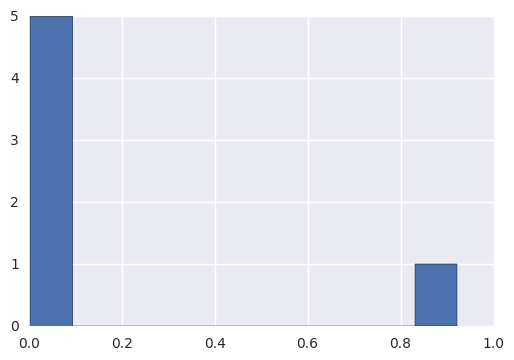

In [51]:
# 重要度を見てみる
X = pd.concat((pd.read_hdf(filename) for filename in TRAINS), axis=1)
columns = X.columns
y = pd.read_hdf(RESPONSE).loc[X.index].values.ravel()
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)
plt.hist(clf.feature_importances_[clf.feature_importances_>0])

In [52]:
tuples = []
for i in range(len(columns)):
    fi = clf.feature_importances_[i]
    if fi <= 0.001:
        print(columns[i])
        continue
    tuples.append((fi, columns[i]))
    
tuples = sorted(tuples, reverse=True)
for t in tuples:
    print(t)

L0_max
L1_min
L1_max
L1_min_max
L2_max
L2_min_max
L3_min
L3_max
L3_min_max
max
min_max
L0_date_MD5
L1_date_MD5
L2_date_MD5
date_MD5
(0.92236024, 'L3_date_MD5')
(0.031055901, 'L3_S32_F3854')
(0.018633541, 'min')
(0.01242236, 'L2_min')
(0.01242236, 'L0_min')
(0.0031055901, 'L0_min_max')


In [55]:
colums = [c[1] for c in tuples]
X = pd.concat((pd.read_hdf(filename) for filename in TRAINS), axis=1)
y = pd.read_hdf(RESPONSE)

In [56]:
X = X.loc[:, columns]
X = X.values
y = y.values.ravel()

In [57]:
# 予測して Cross Validation
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
predictions = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    predictions[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:, 1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], predictions[test])))
print(roc_auc_score(y, predictions))

fold 0, ROC AUC: 0.700
fold 1, ROC AUC: 0.667
fold 2, ROC AUC: 0.678
0.682704893553


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.139377117196


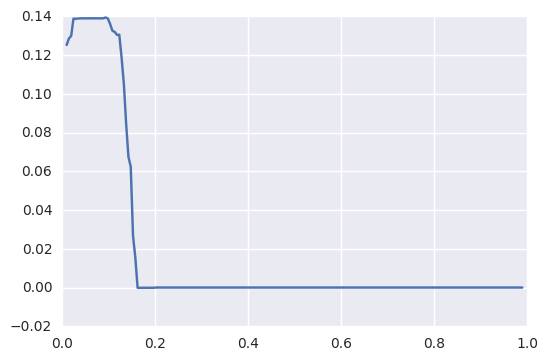

In [58]:
# MCC 最適化
thresholds = np.linspace(0.01, 0.99, 200)
mcc = np.array([matthews_corrcoef(y, predictions > thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [59]:
# この時点での当たり具合を出力
tmp_threshold = best_threshold
response = pd.read_hdf(RESPONSE)
response["prediction"] = predictions
predicted_one = response[response["prediction"] > tmp_threshold].groupby("Response").count()
predicted_one.rename(columns={"prediction":"Predict 1.0"}, inplace=True)
predicted_zero = response[response["prediction"] <= tmp_threshold].groupby("Response").count()
predicted_zero.rename(columns={"prediction":"Predict 0.0"}, inplace=True)
pd.concat([predicted_one, predicted_zero], axis=1)

,Predict 1.0,Predict 0.0
Response,,
0.0,3946,1172922
1.0,822,6057


提出用データを生成する

In [17]:
# テストデータ読み込み
X = pd.concat((pd.read_hdf(filename) for filename in TESTS), axis=1)
index = X.index
X = X.values
# 0 or 1 に正規化
predictions = (clf.predict_proba(X)[:, 1] > best_threshold).astype(np.int8)

# 提出データを生成
sub = pd.DataFrame(index=index, columns=[])
sub["Response"] = predictions
sub.to_csv("submission.csv.gz", compression="gzip")